# Notebook d'Exploration

---

## Mise en place et nettoyage

Librairies et paramétrages utilisés au long de ce notebook

In [1]:
import datetime as dt
from string import ascii_letters
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py

In [2]:
%matplotlib inline
sns.set(style="white")
sns.set_context("notebook")

mpl.rcParams['figure.dpi'] = 100

Chargeons les données et affichons-en un aperçu

In [3]:
dtypes = {'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity': np.int64, 
          'InvoiceDate': 'datetime64[ns]', 'UnitPrice': np.float64, 'CustomerID': np.float64, 'Country': str}
data = pd.read_excel('data/Online Retail.xlsx', dtype=dtypes)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Description des informations que nous possédons sur cette table

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Nous observons qu'il y a certaines valeurs manquantes. Quantifions leur proportion par attribut.

In [5]:
data.isnull().sum() / len(data)

InvoiceNo      0.000000
StockCode      0.000000
Description    0.000000
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

Étant donné que notre objectif est de pouvoir segmenter les clients, nous devons supprimer les observations avec `CustomerID` manquant. Cela représente environ 25% du total des lignes de la table initiale.

In [6]:
data = data[data.CustomerID.notnull()]
data['CustomerID'] = data.CustomerID.astype(np.int)
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Afin de s'assurer de l'égale représentativité de chaque mois dans nos données, nous décidons de supprimer les lignes ayant été enregistrées après le 01/12/2011, étant donné que nous possédons déjà des informations sur le mois de Décembre 2010.

In [7]:
data = data[data.InvoiceDate.dt.to_pydatetime() < dt.datetime(2011, 12, 1)]

Exportons cette table dans un format plus rapide à lire auquel nous accèderons directement pour la suite pour l'exploration.

In [8]:
data.reset_index(drop=True, inplace=True)
data.to_feather('data/clean_data')

---

## Exploration des données

In [9]:
data = pd.read_feather('data/clean_data')

Combien de clients, de factures, et de pays d'origines différents sont présents dans notre base de données?

In [10]:
for var in ['Country', 'InvoiceNo', 'CustomerID']:
    print(f"{var:12} {data[var].unique().size}")

Country      37
InvoiceNo    21269
CustomerID   4331


### Pays d'origine

Il y a 37 pays d'origine différents. Essayons de mieux comprendre la répartition des clients visuellement sur une carte.

In [45]:
# Count number of clients per country
customers = data[['Country', 'CustomerID']].drop_duplicates()

df = (customers.groupby(by='Country')
      .count()
      .divide(len(customers)/100)
      .round(3)
      .reset_index())

plot_data = dict(
    type = 'choropleth', 
    locations = df['Country'],
    locationmode = 'country names',
    z = df['CustomerID'],
    text = df['Country'],
    colorscale = 'YlGnBu',
    reversescale = True,
    colorbar = {'title': 'Proportion of Customers'}
)

layout = dict(
    title = 'Proportion of customers in the database per country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        showcountries = True,
        projection = {'type': 'Mercator'}
    )
)

fig = dict(data=[plot_data], layout=layout )
py.iplot(fig, validate=False, filename='oc_p5_customersmap' )

Sans surprise, la très grande majorité des clients de ce commerce en ligne anglais viennent du Royaume-Uni. Affichons la proportion de clients venant du Royaume-Uni et de l'étranger.

90.0% des clients viennent du Royaume-Uni


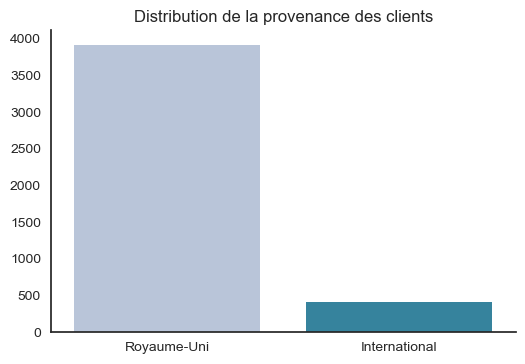

In [12]:
is_uk = (customers.Country == "United Kingdom").sum()
not_uk =(~customers.Country.isin(["Unspecified", "United Kingdom"])).sum()

sns.barplot(x=['Royaume-Uni', 'International'], y=[is_uk, not_uk], palette=sns.color_palette('PuBuGn', 2));
plt.title('Distribution de la provenance des clients')
sns.despine();
print(f"{round(is_uk/customers.shape[0]*100)}% des clients viennent du Royaume-Uni")

Nous gardons cette dichotomie dans un nouvel attribut, `is_UK`

In [13]:
data['is_UK'] = data.Country.apply(lambda x: 1 if x == 'United Kingdom' else 0)

### Unité d'observations: Factures

Pour cette sous-partie, changeons d'unité d'observation et intéressons-nous aux factures (*invoices*)

In [14]:
invoices = pd.DataFrame({'InvoiceNo': pd.Series(data.InvoiceNo.unique())})
invoices['is_cancelled'] = invoices.InvoiceNo.str.startswith('C', na=False)
invoices.set_index('InvoiceNo', drop=True, inplace=True)

Sur l'ensemble de factures que nous possédons, certaines notifient des annulations. Celles-ci sont repérables par un identifiant commençant par la lettre `C`. Comparons la proportion de factures confirmées et annulées. 

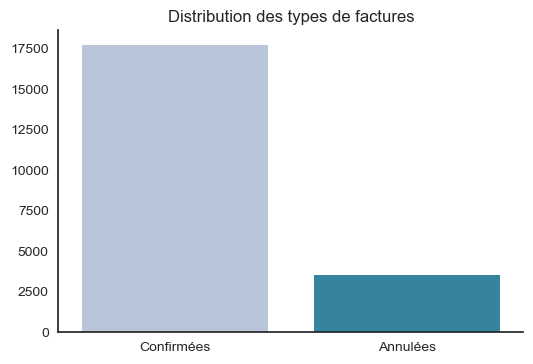

In [15]:
all_invoices = invoices.shape[0]
c_invoices = invoices.is_cancelled.sum()

sns.barplot(x=['Confirmées', 'Annulées'], y=[all_invoices-c_invoices, c_invoices], palette=sns.color_palette('PuBuGn', 2))
plt.title('Distribution des types de factures')
sns.despine();

Pour mieux comprendre la composition de ces factures, observons la distribution du nombre de produits qu'elles possèdent

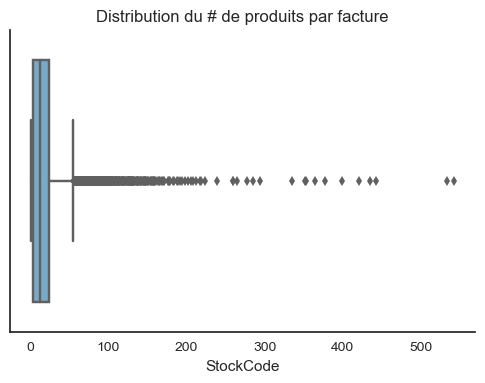

In [16]:
products_per_invoice = (data[['InvoiceNo', 'StockCode']]
                        .groupby(by='InvoiceNo')
                        .count()
                        .join(invoices))

sns.boxplot(products_per_invoice.StockCode, palette='Blues')
plt.title('Distribution du # de produits par facture')
sns.despine();

Aussi, intéressons-nous au sous-total de tous ces produits par facture 

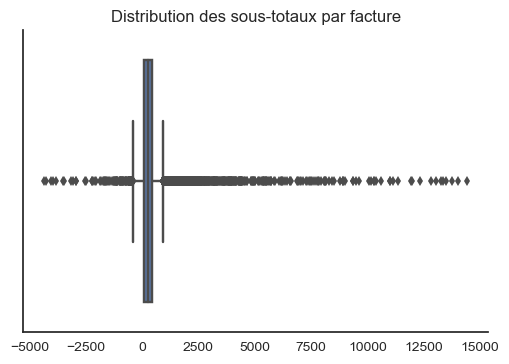

In [17]:
invoices_total = (data[['InvoiceNo', 'Quantity', 'UnitPrice']]
                  .groupby('InvoiceNo')
                  .apply(lambda x: x.Quantity*x.UnitPrice)
                  .groupby('InvoiceNo').sum())

sns.boxplot(invoices_total[invoices_total.between(-5e3, 15e3)])
plt.title('Distribution des sous-totaux par facture')
sns.despine();

Les deux dernières visualisations nous amènent à la même interprétation: la plupart des factures semblent être de 'petites' factures (peu de produits, à prix peu élevés). Mais il existe de nombreux cas hors des _moustaches_ de notre boxplot (factures élevées, beaucoup de produits), et la deuxième visualisation nous permet de dire que ces cas se produisent aussi bien pour les factures confirmées que les factures annulées.

### Unité d'observations: Clients

#### Fidélité

Intéressons-nous encore à une autre unité d'observation: les clients, et leur fidélité dans le temps. Calculons pour chacun d'entre eux le nombre de transactions qu'ils effectuent par mois.

In [18]:
data['Month'] = data.InvoiceDate.dt.month
invoices_per_month = data.pivot_table(values='InvoiceNo', index='CustomerID', 
                                      columns='Month', aggfunc=np.count_nonzero, fill_value=0)
invoices_per_month.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
CustomerID,,,,,,,,,,,,
12346,2,0,0,0,0,0,0,0,0,0,0,0
12347,29,0,0,24,0,18,0,22,0,47,0,31
12348,6,0,0,5,0,0,0,0,3,0,0,17
12349,0,0,0,0,0,0,0,0,0,0,73,0
12350,0,17,0,0,0,0,0,0,0,0,0,0


Visualisons ce nombre de transactions par mois sur l'ensemble de la clientèle

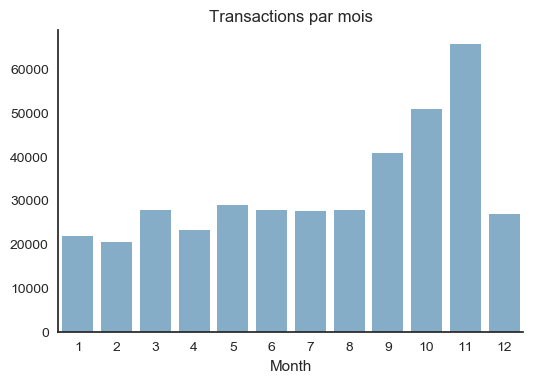

In [19]:
sns.barplot(data=invoices_per_month, estimator=np.sum, ci=None, color=sns.color_palette('PuBuGn', 12)[5])
plt.title('Transactions par mois')
sns.despine();

Comparons cela avec le nombre de clients uniques qui achètent par mois

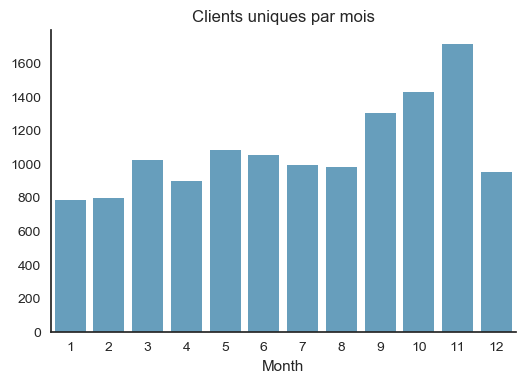

In [20]:
sns.barplot(data=invoices_per_month, estimator=np.count_nonzero, ci=None, color=sns.color_palette('PuBuGn', 12)[6])
plt.title('Clients uniques par mois')
sns.despine();

Nous observons que les deux graphiques ont à peu près la même tendance, signifiant que certains clients n'influencent par à eux seuls sur le nombre de transactions mensuelles.

#### Sous-totaux

D'abord, calculons le sous-total pour chaque ligne de *panier*, telles que présentées dans notre table initiale.

In [21]:
data['Subtotal'] = data['UnitPrice'] * data['Quantity'] 

Ensuite, pour chaque client, faisons la somme de ces sous-totaux. Nous obtiendrons alors leur dépense totale sur la période relevée dans notre jeu de données.

In [22]:
total_per_customer = (data[['CustomerID', 'Subtotal']]
                      .groupby(by=['CustomerID'])
                      .sum())
total_per_customer.head()

,Subtotal
CustomerID,
12346,0.00
12347,4085.18
12348,1797.24
12349,1757.55
12350,334.40


Affichons la distribution de cette variable à l'aide d'un boxplot

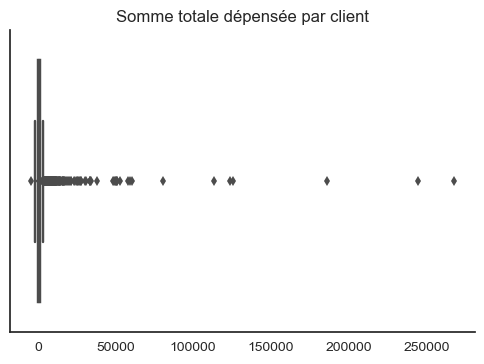

In [23]:
sns.boxplot(total_per_customer)
plt.title('Somme totale dépensée par client')
sns.despine();

Nous observons une distribution quasi-exponentielle. Zoomons sur les clients ayant un sous-total de £10k pour avoir une idée plus précise de la distribution de la plupart des clients

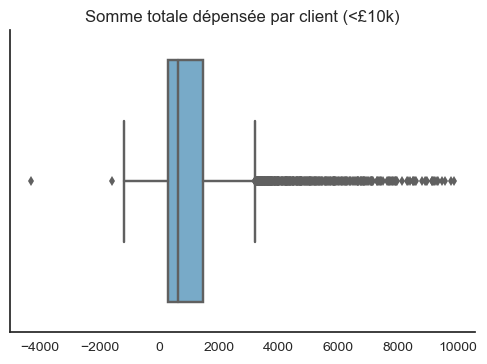

In [24]:
sns.boxplot(total_per_customer[total_per_customer < 10000], palette='Blues')
plt.title('Somme totale dépensée par client (<£10k)')
sns.despine();

On remarque que la plupart des clients ont un sous-total inférieur à £3k. Nous pouvons décomposer arbitrairement l'ensemble de notre clientèle suivant leur sous-total comme suit, d'après les informations données par nos deux dernières visualisations.

In [25]:
print(f"Clients au total: {total_per_customer.shape[0]}")
print(f"Clients < £3k: {(total_per_customer.Subtotal < 3000).sum()}")
print(f"Clients [£3k, £50k]: {(total_per_customer.Subtotal.between(3000, 50000)).sum()}")
print(f"Clients > £50k: {(total_per_customer.Subtotal > 50000).sum()}")

Clients au total: 4331
Clients < £3k: 3812
Clients [£3k, £50k]: 504
Clients > £50k: 15


In [26]:
data.to_feather('data/purchases')

---

## Feature engineering

Afin de pouvoir segmenter nos clients dans une phase ultérieure de notre analyse, nous devons créer des descripteurs _synthétiques_ à partir des informations données par leurs paniers achats. Nous nous proposons de créer pour chaque client les descripteurs suivants, qui contiennent aussi bien des informations sur leurs dépenses, la variété et leur fréquence d'achats:
- Nombre de produits uniques
- Nombre de produits moyen par facture
- Prix unitaire moyen des produits uniques
- Dépense totale
- Dépense moyenne par facture
- Nombre de factures annulées
- Nombres de transactions
- Nombres de mois avec transaction
- Durée moyenne inversée entre deux transactions
- Informations premier achat (nombre de produits uniques, dépense totale, prix unitaire moyen)

In [27]:
all_features = []

Nombre de produits différents par clients

In [28]:
nprods = (data.groupby('CustomerID')
          .agg({'StockCode': 'nunique'})
          .rename(columns={'StockCode': 'Products_unique'}))
all_features.append(nprods)

nprods.head()

,Products_unique
CustomerID,
12346,1
12347,100
12348,22
12349,73
12350,17


Nombre de produits moyen par facture

In [29]:
tmp = (data.groupby(['CustomerID', 'InvoiceNo'])
       .agg({'StockCode': 'nunique'})
       .reset_index(level=1))
# Count negatively items from C* invoices
tmp['StockCode'] = np.where(tmp.InvoiceNo.str.startswith('C'), 
                            -tmp.StockCode, tmp.StockCode)

mean_prods = (tmp.groupby('CustomerID')
              .agg({'StockCode': 'mean'})
              .round(2)
              .rename(columns={'StockCode': 'Prods_per_invoice'}))
all_features.append(mean_prods)

mean_prods.head()

,Prods_per_invoice
CustomerID,
12346,0.00
12347,28.50
12348,6.75
12349,73.00
12350,17.00


Prix unitaire moyen

In [30]:
unit_avg = (data[['CustomerID', 'StockCode', 'UnitPrice']]
            .drop_duplicates()
            .groupby('CustomerID')
            .agg({'UnitPrice': 'mean'})
            .round(2)
            .rename(columns={'UnitPrice': 'Unit_avg'}))
all_features.append(unit_avg)

unit_avg.head()

,Unit_avg
CustomerID,
12346,1.04
12347,2.44
12348,2.16
12349,8.29
12350,3.84


Dépense totale

In [31]:
spending_total = (data.groupby('CustomerID')
                  .agg({'Subtotal': 'sum'})
                  .round(2)
                  .rename(columns={'Subtotal': 'Spending_total'}))
all_features.append(spending_total)

spending_total.head()

,Spending_total
CustomerID,
12346,0.00
12347,4085.18
12348,1797.24
12349,1757.55
12350,334.40


Dépense moyenne par facture

In [32]:
spending_avg = (data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)
                .agg({'Subtotal': 'sum'})
                .groupby('CustomerID')
                .agg({'Subtotal': 'mean'})
                .round(2)
                .rename(columns={'Subtotal': 'Spending_avg'}))
all_features.append(spending_avg)

spending_avg.head()

,Spending_avg
CustomerID,
12346,0.00
12347,680.86
12348,449.31
12349,1757.55
12350,334.40


Nombre de factures annulées

In [33]:
def count_cancelled(s):
    return s.str.startswith('C').sum()

n_cancelled = (data.groupby('CustomerID')
               .agg({'InvoiceNo': count_cancelled})
               .rename(columns={'InvoiceNo': 'N_cancelled'}))
all_features.append(n_cancelled)

n_cancelled.head()

,N_cancelled
CustomerID,
12346,1
12347,0
12348,0
12349,0
12350,0


Nombre de transactions

In [34]:
n_transactions = (data.groupby('CustomerID')
                  .agg({'InvoiceNo': 'nunique'})
                  .rename(columns={'InvoiceNo': 'N_transactions'}))
all_features.append(n_transactions)

n_transactions.head()

,N_transactions
CustomerID,
12346,2
12347,6
12348,4
12349,1
12350,1


Nombre de mois où le client fait des transactions

In [35]:
month_activity = (data.groupby('CustomerID')
                  .agg({'Month': 'nunique'})
                  .rename(columns={'Month': 'N_months'}))
all_features.append(month_activity)

month_activity.head()

,N_months
CustomerID,
12346,1
12347,6
12348,4
12349,1
12350,1


Durée moyenne entre deux transactions, inversée

In [36]:
def delta_days(s):
    unique_days = np.unique(s)
    diffs = np.diff(unique_days) / np.timedelta64(1, 'D')
    if not diffs.size:
        return 0
    return 1/diffs.mean()

timebtw_inv = (data.groupby(['CustomerID'], )['InvoiceDate']
               .apply(np.unique)
               .apply(delta_days)
               .to_frame()
               .rename(columns={'InvoiceDate': 'Timebtw_inv'}))
all_features.append(timebtw_inv)

timebtw_inv.head()

,Timebtw_inv
CustomerID,
12346,90.000000
12347,0.015249
12348,0.010610
12349,0.000000
12350,0.000000


Pays de résidence

In [37]:
residency = data.groupby('CustomerID').agg({'is_UK': np.mean})
residency.is_UK.value_counts()

1    3916
0     415
Name: is_UK, dtype: int64

### Premières transactions

Mettre les données en forme

In [38]:
first_transactions = (data[['CustomerID', 'InvoiceNo', 'InvoiceDate']]
                      .drop_duplicates()
                      .sort_values('InvoiceDate')
                      .groupby('CustomerID')
                      .first())

data_first = data[data.InvoiceNo.isin(first_transactions.InvoiceNo)]

Nombre de produits différents (à la 1ère transaction)

In [39]:
first_nprods = (data_first.groupby(by='CustomerID')
                .agg({'StockCode': 'nunique'})
                .rename(columns={'StockCode': 'First_unique'}))
all_features.append(first_nprods)

first_nprods.head()

,First_unique
CustomerID,
12346,1
12347,31
12348,13
12349,73
12350,17


Dépense totale (à la 1ère transaction)

In [40]:
first_spending = (data_first.groupby(by='CustomerID')
                  .agg({'Subtotal': 'sum'})
                  .round(2)
                  .rename(columns={'Subtotal': 'First_spending'}))
all_features.append(first_spending)

first_spending.head()

,First_spending
CustomerID,
12346,77183.60
12347,711.79
12348,892.80
12349,1757.55
12350,334.40


Prix unité moyen (à la 1ère transaction)

In [41]:
first_units = (data_first[['CustomerID', 'StockCode', 'UnitPrice']]
               .drop_duplicates()
               .groupby('CustomerID')
               .agg({'UnitPrice': 'mean'})
               .round(2)
               .rename(columns={'UnitPrice': 'First_units'}))
all_features.append(first_units)

first_units.head()

,First_units
CustomerID,
12346,1.04
12347,2.89
12348,2.92
12349,8.29
12350,3.84


### DataFrame Finale

Joignons tous les descripteurs précédemment créés dans une même DataFrame, avec comme clé primaire du code client `CustomerID`

In [42]:
final_df = residency.join(all_features)
final_df.head()

,is_UK,Products_unique,Prods_per_invoice,Unit_avg,Spending_total,Spending_avg,N_cancelled,N_transactions,N_months,Timebtw_inv,First_unique,First_spending,First_units
CustomerID,,,,,,,,,,,,,
12346,1,1,0.00,1.04,0.00,0.00,1,2,1,90.000000,1,77183.60,1.04
12347,0,100,28.50,2.44,4085.18,680.86,0,6,6,0.015249,31,711.79,2.89
12348,0,22,6.75,2.16,1797.24,449.31,0,4,4,0.010610,13,892.80,2.92
12349,0,73,73.00,8.29,1757.55,1757.55,0,1,1,0.000000,73,1757.55,8.29
12350,0,17,17.00,3.84,334.40,334.40,0,1,1,0.000000,17,334.40,3.84


Faisons une exploration brève de nos descripteurs synthétiques en calculant leur cœfficient de corrélation deux à deux, afin de nous assurer que nous n'avons pas de liaisons fortes entre eux, et donc une certaine hétérogénéité.

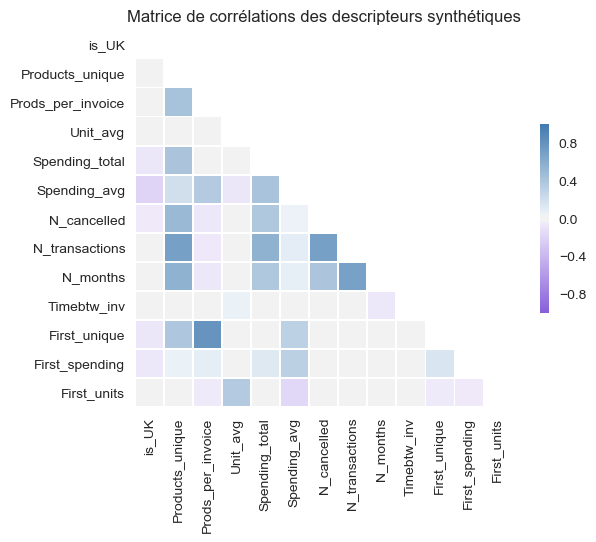

In [43]:
# Parameters
corr = final_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(275, 245, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matrice de corrélations des descripteurs synthétiques');

Enfin, nous sauvegardons cette DataFrame afin de pouvoir exploiter ces informations pour segmenter notre clientèle dans un notre notebook.

In [44]:
final_df.reset_index().to_feather('data/features')